# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fftpack import dct
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time
import tensorflow as tf

# Loading the MNIST dataset
reducing it to 1000 image per class for train and 200 image per class for test

In [2]:
# Load the full MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize images
train_images, test_images = train_images / 255.0, test_images / 255.0

# Create a reduced version with 1000 training examples and 200 test examples per digit
def create_reduced_mnist(images, labels, samples_per_digit):
    reduced_images = []
    reduced_labels = []
    
    # For each digit (0-9)
    for digit in range(10):
        # Find indices where the digit appears
        indices = np.where(labels == digit)[0]
        
        # Randomly select the specified number of samples
        selected_indices = np.random.choice(indices, samples_per_digit, replace=False)
        
        # Add selected samples to reduced dataset
        reduced_images.append(images[selected_indices])
        reduced_labels.append(labels[selected_indices])
    
    # Combine and shuffle the reduced dataset
    reduced_images = np.vstack(reduced_images)
    reduced_labels = np.hstack(reduced_labels)
    
    # Create a shuffled index array
    shuffle_idx = np.random.permutation(len(reduced_labels))
    
    return reduced_images[shuffle_idx], reduced_labels[shuffle_idx]

# Create reduced training set (1000 examples per digit)
reduced_train_images, reduced_train_labels = create_reduced_mnist(train_images, train_labels, 1000)

# Create reduced test set (200 examples per digit)
reduced_test_images, reduced_test_labels = create_reduced_mnist(test_images, test_labels, 200)

print(f"Original training set shape: {train_images.shape}, {train_labels.shape}")
print(f"Reduced training set shape: {reduced_train_images.shape}, {reduced_train_labels.shape}")
print(f"Original test set shape: {test_images.shape}, {test_labels.shape}")
print(f"Reduced test set shape: {reduced_test_images.shape}, {reduced_test_labels.shape}")

# Verify distribution of digits in reduced datasets
for digit in range(10):
    train_count = np.sum(reduced_train_labels == digit)
    test_count = np.sum(reduced_test_labels == digit)
    print(f"Digit {digit}: {train_count} training examples, {test_count} test examples")

Original training set shape: (60000, 28, 28), (60000,)
Reduced training set shape: (10000, 28, 28), (10000,)
Original test set shape: (10000, 28, 28), (10000,)
Reduced test set shape: (2000, 28, 28), (2000,)
Digit 0: 1000 training examples, 200 test examples
Digit 1: 1000 training examples, 200 test examples
Digit 2: 1000 training examples, 200 test examples
Digit 3: 1000 training examples, 200 test examples
Digit 4: 1000 training examples, 200 test examples
Digit 5: 1000 training examples, 200 test examples
Digit 6: 1000 training examples, 200 test examples
Digit 7: 1000 training examples, 200 test examples
Digit 8: 1000 training examples, 200 test examples
Digit 9: 1000 training examples, 200 test examples


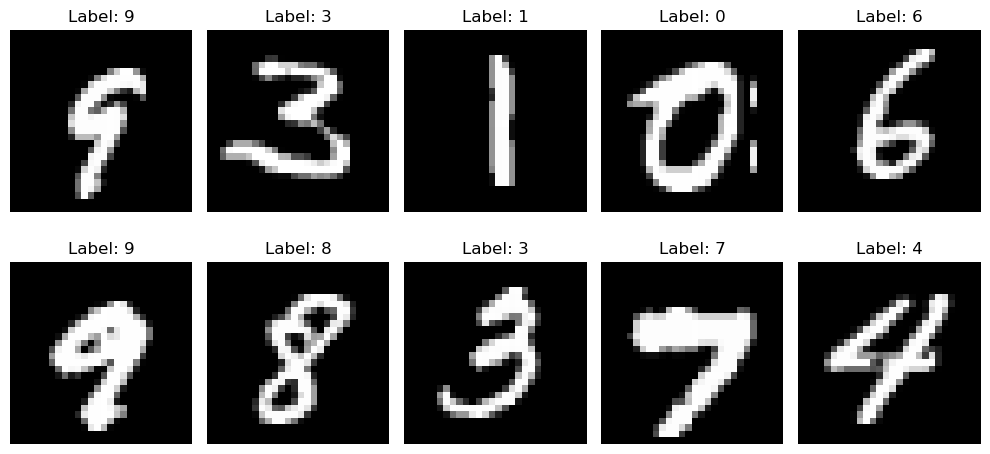

In [3]:
# Function to display random samples
def show_samples(images, labels, num_samples=10):
    plt.figure(figsize=(10, 5))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 10 random samples from the training set
show_samples(reduced_train_images, reduced_train_labels)


# Feature Generation

## 1- DCT (Discrete cosine transform)
Using 225 dimensions

✅ What is DCT?

DCT is a mathematical transformation that converts spatial data (images) into frequency components. It represents the image as a sum of cosine functions oscillating at different frequencies.
- Low-frequency components capture smooth areas (background, gradual changes).
- High-frequency components capture edges and textures (sharp transitions).
- DCT is widely used in image compression (like JPEG) because most of the important information in an image is concentrated in the low frequencies, allowing us to discard the high frequencies for compression.

🔍 How does DCT work?
1. Transform the image: For each image, apply the 2D DCT. It converts the image from the spatial domain (pixel values) to the frequency domain (cosine coefficients).
2. Keep the most important features: Typically, you only keep the top-left corner of the DCT matrix because it contains the low-frequency components. Example: Keeping the first 225 DCT coefficients (15 × 15 patch) for each image.
3. Reduce dimensionality: Instead of using 784 pixels (28 × 28 MNIST image), you use the 225 most important frequencies.

In [4]:
# Function to extract DCT features
def extract_dct_features(images):
    dct_features = []
    for img in images:
        img_dct = dct(dct(img, axis=0), axis=1)[:15, :15]  # Take top-left 15x15 coefficients
        dct_features.append(img_dct.flatten())
    return np.array(dct_features)

In [28]:
# Extract DCT features
train_dct_features = extract_dct_features(reduced_train_images)
test_dct_features = extract_dct_features(reduced_test_images)
print("train_dct_features shape:", train_dct_features.shape)
print("test_dct_features shape:", test_dct_features.shape)

train_dct_features shape: (10000, 225)
test_dct_features shape: (2000, 225)


## 2- PCA (Principal component analysis)
Using several dimensions so that the total variance is at least 95% of the total variance when using all the 784 dimensions.

✅ What is PCA?

PCA is a linear dimensionality reduction technique. It finds the directions (components) in the dataset where the data varies the most and projects the data along those directions.

In simpler terms:

- It identifies patterns and correlations in the data.
- It keeps the most informative features while removing noise and redundancy.

🔍 How does PCA work?
1. **Standardize the dataset:** Ensure the dataset has mean = 0 and variance = 1 (especially for large datasets).
2. **Compute the covariance matrix:** Measure how much features (pixels) vary together.
3. **Eigen decomposition:** Identify principal components—the axes that capture the maximum variance.
4. **Project the data:** Keep the top components to reduce dimensionality while retaining most of the information.

**For this task:** We select enough components to retain 95% of the variance in the dataset. This often reduces the 784 features to around 150-200 PCA components.

In [6]:
# Reshape the images from 28x28 to 784 (flattening)
n_train = reduced_train_images.shape[0]
n_test = reduced_test_images.shape[0]
train_data_flat = reduced_train_images.reshape(n_train, -1)
test_data_flat = reduced_test_images.reshape(n_test, -1)

# Fit PCA on the training data
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
pca.fit(train_data_flat)

# Transform both training and test data
train_data_pca = pca.transform(train_data_flat)
test_data_pca = pca.transform(test_data_flat)

# Print information about the PCA transformation
n_components = pca.n_components_
print(f"Number of PCA components needed for 95% variance: {n_components}")
print(f"Original feature dimension: 784")
print(f"Reduced feature dimension: {n_components}")
print(f"Dimension reduction: {100 * (784 - n_components) / 784:.2f}%")


# Print the shape of the new feature sets
print(f"PCA-transformed training data shape: {train_data_pca.shape}")
print(f"PCA-transformed test data shape: {test_data_pca.shape}")

Number of PCA components needed for 95% variance: 152
Original feature dimension: 784
Reduced feature dimension: 152
Dimension reduction: 80.61%
PCA-transformed training data shape: (10000, 152)
PCA-transformed test data shape: (2000, 152)


# Classifiers

## 1- K-means
Trying 1, 4, 16, and 32 clusters for each class.

✅ What is K-Means?

K-Means is an unsupervised clustering algorithm. It groups data points into K clusters based on their similarity.

🔍 How does K-Means work?

1. Choose K clusters: We specify how many clusters we want (e.g., K = 1, 4, 16, or 32 for each digit in our case).

2. Initialize cluster centers: Randomly select K points as the initial cluster centers.

3. Assign points to the nearest cluster: Each data point is assigned to the cluster whose center is closest (measured by Euclidean distance).

4. Update cluster centers: Compute the new mean position of all points within each cluster.

5. Repeat: Continue reassigning points and updating cluster centers until convergence (when cluster assignments no longer change significantly).

### K-means setup

In [17]:
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

def train_kmeans_per_class(X_train, y_train, n_clusters):
    """
    Train a separate K-means model for each class.
    
    Args:
        X_train: Training features
        y_train: Training labels
        n_clusters: Number of clusters per class
        
    Returns:
        Dictionary of K-means models, one per class
    """
    models = {}
    for digit in range(10):
        # Get data for this digit only
        digit_indices = np.where(y_train == digit)[0]
        X_digit = X_train[digit_indices]
        
        # Train K-means for this digit
        model = KMeans(n_clusters=n_clusters, random_state=20, n_init=10)
        model.fit(X_digit)
        
        # Store the model
        models[digit] = model
    
    return models

def predict_with_kmeans(X_test, models):
    """
    Predict class labels using the K-means models.
    
    Args:
        X_test: Test features
        models: Dictionary of K-means models, one per class
        
    Returns:
        Predicted class labels
    """
    # Calculate distances to all centroids of all classes
    predictions = []
    
    for i in range(len(X_test)):
        sample = X_test[i]
        min_distance = float('inf')
        predicted_digit = None
        
        # Check distance to centroids of each class
        for digit, model in models.items():
            # Get distances to all centroids for this class
            distances = np.linalg.norm(model.cluster_centers_ - sample.reshape(1, -1), axis=1)
            # Find the minimum distance
            class_min_distance = np.min(distances)
            
            # Update prediction if this is the closest centroid overall
            if class_min_distance < min_distance:
                min_distance = class_min_distance
                predicted_digit = digit
                
        predictions.append(predicted_digit)
    
    return np.array(predictions)

def evaluate_kmeans_clustering(train_data, train_labels, test_data, test_labels, 
                                cluster_counts=[1, 4, 16, 32], 
                                train_kmeans_func=None, 
                                predict_kmeans_func=None):
    """
    Evaluate K-means clustering performance across different numbers of clusters.
    
    Parameters:
    -----------
    train_data : numpy.ndarray
        Training features
    train_labels : numpy.ndarray
        Training labels
    test_data : numpy.ndarray
        Test features
    test_labels : numpy.ndarray
        Test labels
    cluster_counts : list, optional
        Numbers of clusters to evaluate (default: [1, 4, 16, 32])
    train_kmeans_func : callable, optional
        Custom function to train K-means models (default: None)
    predict_kmeans_func : callable, optional
        Custom function to predict using K-means models (default: None)
    
    Returns:
    --------
    dict
        Dictionary containing results and plots
    """
    # Use default functions if not provided
    if train_kmeans_func is None:
        def train_kmeans_func(X_train, y_train, n_clusters):
            from sklearn.cluster import KMeans
            models = {}
            for digit in range(10):
                digit_indices = np.where(y_train == digit)[0]
                X_digit = X_train[digit_indices]
                
                model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                model.fit(X_digit)
                
                models[digit] = model
            
            return models
    
    if predict_kmeans_func is None:
        def predict_kmeans_func(X_test, models):
            predictions = []
            
            for i in range(len(X_test)):
                sample = X_test[i]
                min_distance = float('inf')
                predicted_digit = None
                
                for digit, model in models.items():
                    distances = np.linalg.norm(model.cluster_centers_ - sample.reshape(1, -1), axis=1)
                    class_min_distance = np.min(distances)
                    
                    if class_min_distance < min_distance:
                        min_distance = class_min_distance
                        predicted_digit = digit
                        
                predictions.append(predicted_digit)
            
            return np.array(predictions)
    
    # Results storage
    results = []
    
    # Evaluate for different cluster counts
    for n_clusters in cluster_counts:
        print(f"\nTraining with {n_clusters} clusters per class...")
        
        # Measure training time
        train_start = time.time()
        models = train_kmeans_func(train_data, train_labels, n_clusters)
        train_time = time.time() - train_start
        
        # Measure prediction time
        predict_start = time.time()
        predictions = predict_kmeans_func(test_data, models)
        predict_time = time.time() - predict_start
        
        # Calculate accuracy
        accuracy = accuracy_score(test_labels, predictions)
        
        # Store results
        result = {
            'clusters': n_clusters,
            'train_time': train_time,
            'predict_time': predict_time,
            'total_time': train_time + predict_time,
            'accuracy': accuracy
        }
        results.append(result)
        
        # Print detailed results
        print(f"Clusters per class: {n_clusters}")
        print(f"Training time: {train_time:.2f} seconds")
        print(f"Prediction time: {predict_time:.2f} seconds")
        print(f"Total time: {(train_time + predict_time):.2f} seconds")
        print(f"Accuracy: {accuracy:.4f}")
    
    # Display summary table
    print("\nSummary:")
    print(f"{'Clusters':^10} | {'Train Time':^12} | {'Predict Time':^12} | {'Total Time':^12} | {'Accuracy':^10}")
    print(f"{'-'*10} | {'-'*12} | {'-'*12} | {'-'*12} | {'-'*10}")
    for r in results:
        print(f"{r['clusters']:^10} | {r['train_time']:^12.2f} | {r['predict_time']:^12.2f} | {r['total_time']:^12.2f} | {r['accuracy']:^10.4f}")
    
    # Visualize the results
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy vs number of clusters
    plt.subplot(1, 2, 1)
    plt.plot([r['clusters'] for r in results], [r['accuracy'] for r in results], 'o-', markersize=8)
    plt.xlabel('Number of Clusters per Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Clusters')
    plt.grid(True)
    plt.xscale('log', base=2)
    plt.xticks(cluster_counts, [str(c) for c in cluster_counts])
    
    # Plot processing time vs number of clusters
    plt.subplot(1, 2, 2)
    plt.plot([r['clusters'] for r in results], [r['train_time'] for r in results], 'o-', label='Training Time', markersize=8)
    plt.plot([r['clusters'] for r in results], [r['predict_time'] for r in results], 's-', label='Prediction Time', markersize=8)
    plt.plot([r['clusters'] for r in results], [r['total_time'] for r in results], '^-', label='Total Time', markersize=8)
    plt.xlabel('Number of Clusters per Class')
    plt.ylabel('Time (seconds)')
    plt.title('Processing Time vs Number of Clusters')
    plt.legend()
    plt.grid(True)
    plt.xscale('log', base=2)
    plt.xticks(cluster_counts, [str(c) for c in cluster_counts])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'results': results,
        'plot': plt
    }

### Applying K-means to both DCT and PCA features

=========================Applying K-means clustering on DCT features========================

Training with 1 clusters per class...
Clusters per class: 1
Training time: 7.69 seconds
Prediction time: 0.26 seconds
Total time: 7.95 seconds
Accuracy: 0.7930

Training with 4 clusters per class...
Clusters per class: 4
Training time: 8.13 seconds
Prediction time: 0.30 seconds
Total time: 8.43 seconds
Accuracy: 0.8825

Training with 16 clusters per class...
Clusters per class: 16
Training time: 8.61 seconds
Prediction time: 0.42 seconds
Total time: 9.03 seconds
Accuracy: 0.9240

Training with 32 clusters per class...
Clusters per class: 32
Training time: 9.15 seconds
Prediction time: 0.51 seconds
Total time: 9.66 seconds
Accuracy: 0.9380

Summary:
 Clusters  |  Train Time  | Predict Time |  Total Time  |  Accuracy 
---------- | ------------ | ------------ | ------------ | ----------
    1      |     7.69     |     0.26     |     7.95     |   0.7930  
    4      |     8.13     |     0.30     |

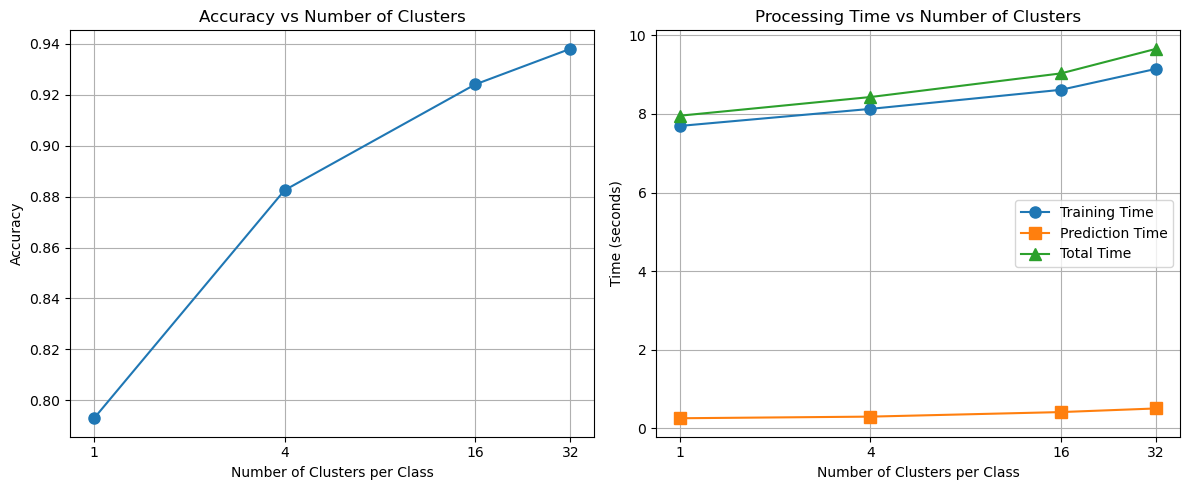

=========================Applying K-means clustering on PCA features========================

Training with 1 clusters per class...
Clusters per class: 1
Training time: 7.61 seconds
Prediction time: 0.25 seconds
Total time: 7.86 seconds
Accuracy: 0.8230

Training with 4 clusters per class...
Clusters per class: 4
Training time: 8.11 seconds
Prediction time: 0.31 seconds
Total time: 8.42 seconds
Accuracy: 0.8970

Training with 16 clusters per class...
Clusters per class: 16
Training time: 8.45 seconds
Prediction time: 0.38 seconds
Total time: 8.82 seconds
Accuracy: 0.9370

Training with 32 clusters per class...
Clusters per class: 32
Training time: 8.96 seconds
Prediction time: 0.45 seconds
Total time: 9.41 seconds
Accuracy: 0.9430

Summary:
 Clusters  |  Train Time  | Predict Time |  Total Time  |  Accuracy 
---------- | ------------ | ------------ | ------------ | ----------
    1      |     7.61     |     0.25     |     7.86     |   0.8230  
    4      |     8.11     |     0.31     |

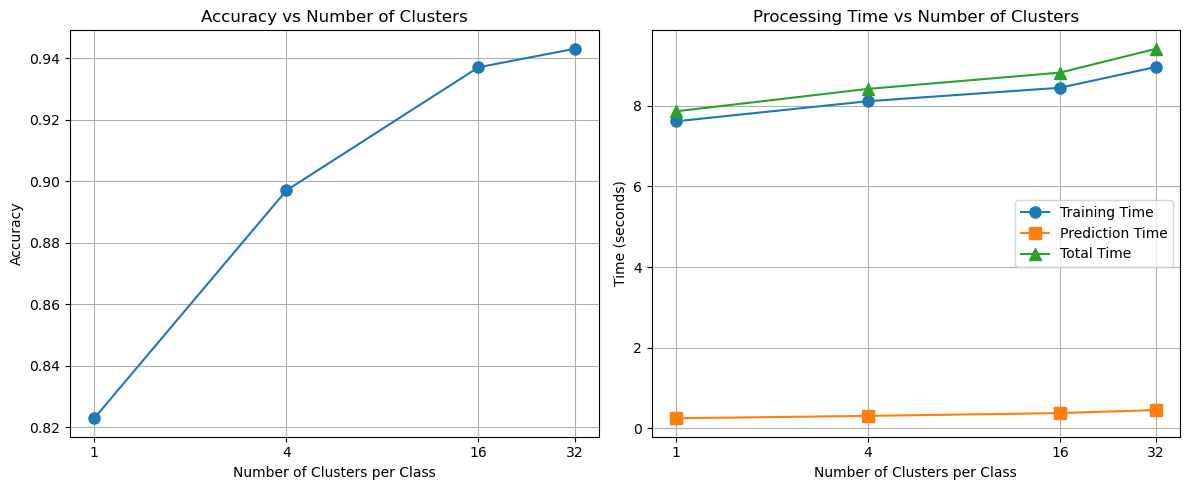

In [18]:
# Test different numbers of clusters
cluster_counts = [1, 4, 16, 32]

# Evaluate k-means clustering on DCT features
print("============================================================================================")
print("=========================Applying K-means clustering on DCT features========================")
print("============================================================================================")
dct_kmeans_results = evaluate_kmeans_clustering(train_dct_features, reduced_train_labels, test_dct_features, reduced_test_labels, cluster_counts)

# Evaluate k-means clustering on PCA features
print("============================================================================================")
print("=========================Applying K-means clustering on PCA features========================")
print("============================================================================================")
pca_kmeans_results = evaluate_kmeans_clustering(train_data_pca, reduced_train_labels, test_data_pca, reduced_test_labels, cluster_counts)

## 2- SVM (Support vector machine)

✅ What is SVM?

Support Vector Machine (SVM) is a supervised learning algorithm used for classification and regression tasks. It is especially powerful for binary classification problems but can also be extended to multi-class classification.

🔍 How does SVM work?

1. **Separate Data with a Hyperplane:** SVM tries to find the best decision boundary (hyperplane) that separates data points from different classes. In 2D, this hyperplane is a line, and in 3D, it’s a plane, but in higher dimensions, it's called a hyperplane.


2. **Maximize the Margin:** SVM doesn’t just find any hyperplane—it finds the one that maximizes the margin between the closest points from each class. These closest points are called support vectors, and they define the decision boundary.


3. **Handle Non-Linearly Separable Data (Using Kernels):** If the data is not linearly separable, SVM uses kernels to transform the data into a higher-dimensional space where it becomes linearly separable. Common kernels:
- Linear Kernel: Works well when the data is linearly separable.
- RBF (Radial Basis Function) Kernel: Handles more complex, non-linear decision boundaries.

4. **Optimize the Model (Soft Margin with C Parameter)**
- The C parameter controls the trade-off between maximizing the margin and minimizing misclassification.
- High C → Less margin, fewer mistakes (overfitting).
- Low C → Larger margin, more mistakes (better generalization).

### SVM Setup

In [25]:
def train_and_evaluate_svm(X_train, y_train, X_test, y_test, kernel='linear', C=1.0, conf_matrix = False):
    """
    Train an SVM model and evaluate its performance.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
        kernel: Kernel type ('linear' or 'rbf')
        C: Regularization parameter
        
    Returns:
        Dictionary with results
    """
    print(f"\nTraining SVM with {kernel} kernel, C={C}...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train SVM model
    model = SVC(kernel=kernel, C=C, gamma='scale', random_state=42)
    
    # Measure training time
    train_start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - train_start
    
    # Measure prediction time
    predict_start = time.time()
    predictions = model.predict(X_test_scaled)
    predict_time = time.time() - predict_start
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)

    # Confusion matrix
    if conf_matrix:
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix (SVM with {kernel} kernel, C={C})')
        plt.show()

    # Count support vectors
    n_support_vectors = model.n_support_.sum()
    
    # Store results
    results = {
        'kernel': kernel,
        'C': C,
        'train_time': train_time,
        'predict_time': predict_time,
        'total_time': train_time + predict_time,
        'accuracy': accuracy,
        'n_support_vectors': n_support_vectors
    }
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {predict_time:.2f} seconds")
    print(f"Total time: {(train_time + predict_time):.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Number of support vectors: {n_support_vectors}")
    
    return results

def display_summary(results):
    # Display summary table
    print("\nSummary:")
    print(f"{'Kernel':^10} | {'C':^5} | {'Train Time':^12} | {'Predict Time':^12} | {'Total Time':^12} | {'Accuracy':^10} | {'Support Vectors':^15}")
    print(f"{'-'*10} | {'-'*5} | {'-'*12} | {'-'*12} | {'-'*12} | {'-'*10} | {'-'*15}")
    for r in results:
        print(f"{r['kernel']:^10} | {r['C']:^5.1f} | {r['train_time']:^12.2f} | {r['predict_time']:^12.2f} | {r['total_time']:^12.2f} | {r['accuracy']:^10.4f} | {r['n_support_vectors']:^15}")

### Using SVM for both DCT and PCA features

In [19]:
svm_configs = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'rbf', 'C': 1.0},
]
dct_svm_results = []
pca_svm_results = []

# Apply SVM on DCT features
print("============================================================================================")
print("=========================    Using SVM Classifier on DCT features   ========================")
print("============================================================================================")
for config in svm_configs:
    result = train_and_evaluate_svm(
        train_dct_features, reduced_train_labels, 
        test_dct_features, reduced_test_labels,
        kernel=config['kernel'], 
        C=config['C']
    )
    dct_svm_results.append(result)

display_summary(dct_svm_results)

# Apply SVM on PCA features
print("============================================================================================")
print("=========================    Using SVM Classifier on PCA features   ========================")
print("============================================================================================")
for config in svm_configs:
    result = train_and_evaluate_svm(
        train_data_pca, reduced_train_labels, 
        test_data_pca, reduced_test_labels,
        kernel=config['kernel'], 
        C=config['C']
    )
    pca_svm_results.append(result)

display_summary(pca_svm_results)

=========================    Using SVM Classifier on DCT features   ========================

Training SVM with linear kernel, C=1.0...
Training time: 3.35 seconds
Prediction time: 0.35 seconds
Total time: 3.70 seconds
Accuracy: 0.9110
Number of support vectors: 2445

Training SVM with rbf kernel, C=1.0...
Training time: 4.97 seconds
Prediction time: 2.29 seconds
Total time: 7.26 seconds
Accuracy: 0.9635
Number of support vectors: 5344

Summary:
  Kernel   |   C   |  Train Time  | Predict Time |  Total Time  |  Accuracy  | Support Vectors
---------- | ----- | ------------ | ------------ | ------------ | ---------- | ---------------
  linear   |  1.0  |     3.35     |     0.35     |     3.70     |   0.9110   |      2445      
   rbf     |  1.0  |     4.97     |     2.29     |     7.26     |   0.9635   |      5344      
=========================    Using SVM Classifier on PCA features   ========================

Training SVM with linear kernel, C=1.0...
Training time: 4.06 seconds
Predic

# Plotting confusion matrix for best result for both classifiers (in terms of accuracy)

## K-means best result at number of clusters = 32 and using PCA features (Accuracy = 94.30 %)

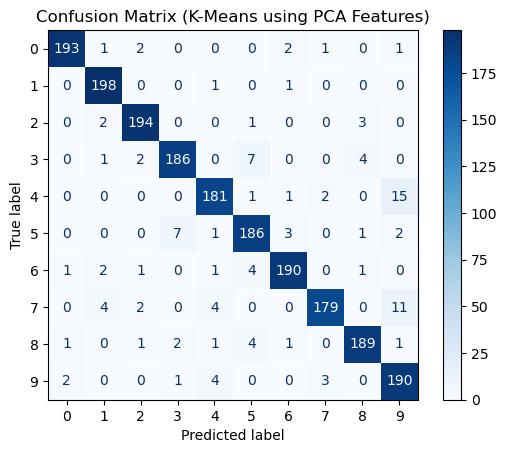

In [22]:

n_clusters = 32
models = train_kmeans_per_class(train_data_pca, reduced_train_labels, n_clusters)

y_pred = predict_with_kmeans(test_data_pca, models)

# Compute and plot confusion matrix
cm = confusion_matrix(reduced_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (K-Means using PCA Features)')
plt.show()

## SVM best result using non-linear kernel RBF and DCT features


Training SVM with rbf kernel, C=1.0...


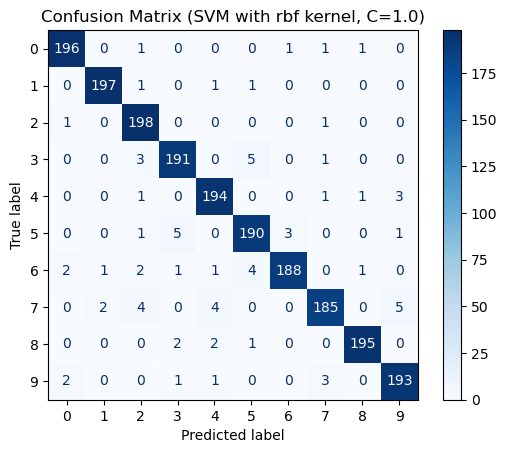

Training time: 5.16 seconds
Prediction time: 2.30 seconds
Total time: 7.46 seconds
Accuracy: 0.9635
Number of support vectors: 5344


In [26]:
result = train_and_evaluate_svm(
        train_dct_features, reduced_train_labels, 
        test_dct_features, reduced_test_labels,
        kernel='rbf', 
        C=1.0,
        conf_matrix=True
    )